this script plots countries' contribution to science

In [1]:
import pandas as pd
import numpy as np
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.patches import Patch

In [2]:
cntry_fund_path='../../data/nf_folder/Data/DerivedData/Derived/cntry_fund_frac.csv'
pubs_path="../../data/nf_folder/Data/DerivedData/CleanedRawData/pub.pkl"
flag_path='../../data/nf_folder/Data/AdditionalData/country_WoS_ECI_WB_flags.tsv'
region_path="../../data/nf_folder/Data/AdditionalData/cntry_region.xlsx"

cntry_funding_path='../../data/nf_folder/Figs/cntry_funding_frac.pdf'

In [3]:
# Parameters
cntry_fund_path = "../data/NationalFunding/Data/DerivedData/Derived/cntry_fund_frac.csv"
pubs_path = "../data/NationalFunding/Data/DerivedData/CleanedRawData/pub.pkl"
flag_path = "../data/NationalFunding/Data/AdditionalData/country_WoS_ECI_WB_flags.tsv"
region_path = "../data/NationalFunding/Data/AdditionalData/cntry_region.xlsx"
cntry_funding_path = "../data/NationalFunding/Figs/Figs/cntry_funding_frac.pdf"


In [4]:
cntry_fund=pd.read_csv(cntry_fund_path)
cntry_fund=cntry_fund[cntry_fund.funder!='Not-Funded']
cntry_fund.head()

,funder,year,intcol,cnt
0,Afghanistan,2010,1,1.000000
1,Afghanistan,2011,1,0.333333
2,Afghanistan,2012,1,0.333333
3,Afghanistan,2015,0,0.148352
4,Afghanistan,2015,1,0.279167


In [5]:
pubs_df = pd.read_pickle(pubs_path)
pubs_df.head()

,id,year,dis,type,author,funder,author_distinct,funder_distinct,funded,IntCol,cofund,intfund
0,60694041,2017,9,1,"[Canada, United States]","[United States, United States]","[Canada, United States]",[United States],1,1,0,0
1,48573156,2012,89,1,[France],Not-Funded,[France],Not-Funded,0,0,0,0
2,55323671,2015,89,1,"[France, Chile]","[Chile, Chile, Chile, Chile, Chile]","[France, Chile]",[Chile],1,1,0,0
3,57633115,2016,31,1,"[Switzerland, United States]",[Switzerland],"[Switzerland, United States]",[Switzerland],1,1,0,0
4,64831413,2018,99,1,[China],"[China, China, China, China, China, China]",[China],[China],1,0,0,0


In [6]:
flag_df=pd.read_csv(flag_path, sep='\t')[['WoS','Code']]
flag_df.head()

,WoS,Code
0,Albania,ALB
1,Algeria,DZA
2,Angola,AGO
3,Argentina,ARG
4,Australia,AUS


In [7]:
region=pd.read_excel(region_path)
region=region[['cntry','region2']]
region=region.rename(columns={'region2':'region'})
region.head()

,cntry,region
0,Algeria,Africa
1,Angola,Africa
2,Belgian Congo,Africa
3,Benin,Africa
4,Botswana,Africa


calculate the number of funded publication each year

In [8]:
def get_fundedann(data,collsig):
    data=data[data.IntCol>=collsig]#to decide whethere include no-international collaboration or not
    funded_ann=data[data.funded==1]
    funded_ann=funded_ann.groupby(['year']).size()
    return funded_ann

normalize country's to proportion

In [9]:
def get_ratio(data,funded_ann,collsig):
    data=data[data.intcol>=collsig]#to decide whethere include no-international collaboration or not
    cntry_ratio=data.groupby(['funder','year'])['cnt'].sum().reset_index()
    cntry_ratio=cntry_ratio.pivot_table(index='year',columns='funder',values='cnt',fill_value=0)
    cntry_ratio=cntry_ratio.div(funded_ann, axis=0)
    return cntry_ratio

In [10]:
n=10
topn=cntry_fund.groupby('funder')[
    'cnt'].sum().sort_values(ascending=False).head(n).index.values


get the contribution of top 10 countries

In [11]:
funded_ann=get_fundedann(pubs_df,0)
cntry_ratio=get_ratio(cntry_fund,funded_ann,0)
topn_df=cntry_ratio[topn].reset_index()
topn_df=topn_df.melt(id_vars='year')  
topn_df=topn_df.merge(flag_df,left_on='funder',right_on='WoS',how='left')

get the contribution to international collaboration of top 10 countries

In [12]:
fundedcoll_ann=get_fundedann(pubs_df,1)
cntrycoll_ratio=get_ratio(cntry_fund,fundedcoll_ann,1)
topn_coll=cntrycoll_ratio[topn].reset_index()
topn_coll=topn_coll.melt(id_vars='year') 
topn_coll=topn_coll.merge(flag_df,left_on='funder',right_on='WoS',how='left')

get the funded publications by regions

In [13]:
regfund=cntry_ratio.reset_index()
regfund=regfund.melt(id_vars='year')
regfund=regfund.merge(region,left_on='funder',right_on='cntry',how='left')
regfund=regfund.groupby(['year','region'])['value'].sum().reset_index(name='count')
regfund=regfund.pivot_table(index='year',columns='region',values='count')


In [14]:
cntry_ratio[['United States', 'China']].sum(axis=1)

year
2009    0.412695
2010    0.409485
2011    0.412156
2012    0.420895
2013    0.430890
2014    0.443855
2015    0.449653
2016    0.458888
2017    0.469645
2018    0.487844
dtype: float64

In [15]:
clist=['#A6341B','#F2506E']+['#D0D2F2']*8
def plot(data,ax,texty,text):
    sns.lineplot(x='year',y='value',hue='funder',data=data,legend=False,
                 ax=ax,hue_order=topn,palette=clist,marker='o',linewidth=1,markersize=5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for ind, code in enumerate(text):
        ax.text(2018,texty[ind],code)
    return ax

In [16]:
regfund.tail(2)

region,Africa,Asia,EU,North America,Oceania,Other Europe,South America
year,,,,,,,
2017,0.007262,0.445982,0.226820,0.21544,0.022313,0.044960,0.037223
2018,0.007074,0.469224,0.215609,0.20524,0.021620,0.043477,0.037755


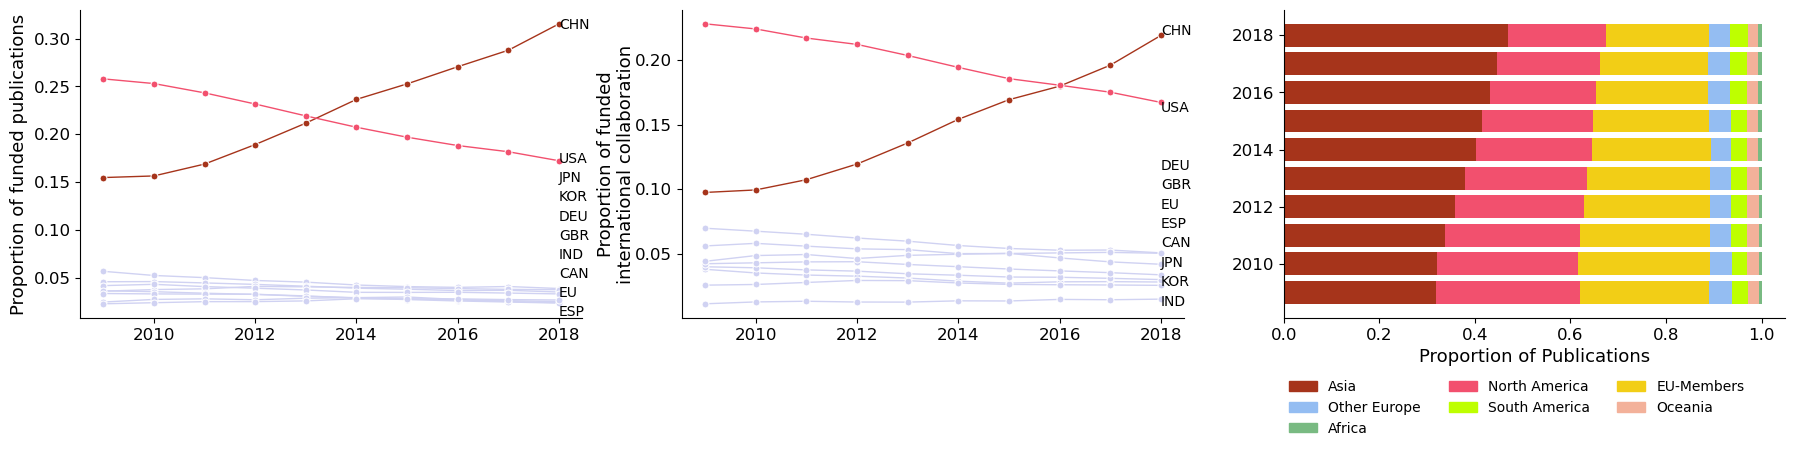

In [17]:
#{'#F2CB05':yellow,'#88C9F2':blue,'#C5C9C7':gray,'#F74F5A'}
years=[2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]

fig, ax=plt.subplots(nrows=1,ncols=3,figsize=(22,4))
ax0=ax[0]
ax1=ax[1]
ax2=ax[2]


texty=[0.31,0.17,0.15,0.13,0.11,0.09,0.07,0.05,0.03,0.01]
text=topn_df[topn_df.year==2018].sort_values(by='value',ascending=False)['Code'].values
plot(topn_df,ax0, texty, text)
ax0.set_xlabel("")
ax0.set_ylabel("Proportion of funded publications",fontsize=13)
ax0.tick_params(axis='both', which='major', labelsize=12)


texty=[0.22,0.16,0.115,0.1,0.085,0.07,0.055,0.04,0.025,0.01]
text=topn_coll[topn_coll.year==2018].sort_values(by='value',ascending=False)['Code'].values
plot(topn_coll,ax1,texty,text)
ax1.set_xlabel("")
ax1.set_ylabel("Proportion of funded\ninternational collaboration",fontsize=13,labelpad=0)
ax1.tick_params(axis='both', which='major', labelsize=12)

asia = regfund.loc[years,'Asia'].values
north = regfund.loc[years,'North America'].values
eu = regfund.loc[years,'EU'].values
othereu = regfund.loc[years,'Other Europe'].values
south = regfund.loc[years,'South America'].values
ocean = regfund.loc[years,'Oceania'].values
africa = regfund.loc[years,'Africa'].values

ax2.barh(years, asia,label='Asia',color='#A6341B')
ax2.barh(years,north,label='North America',left = asia,color='#F2506E')
ax2.barh(years,eu,label='EU-members',left=asia+north,color='#F2CE16')
ax2.barh(years,othereu,label='Other Europe',left=asia+north+eu,color='#94BDF2')
ax2.barh(years,south,label='South America',left=asia+north+eu+othereu,color='#BEFF00')
ax2.barh(years,ocean,label='Oceania',left=asia+north+eu+othereu+south,color='#F3B19A')
ax2.barh(years,africa,label='Africa',left=asia+north+eu+othereu+south+ocean,color='#79BA82')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=12)
legend=[Patch(label='Asia',color='#A6341B'),
        Patch(label='Other Europe',color='#94BDF2'),
        Patch(label='Africa',color='#79BA82'),
        Patch(label='North America',color='#F2506E'),
        Patch(label='South America',color='#BEFF00'),
        Patch(label='EU-Members',color='#F2CE16'),
        Patch(label='Oceania',color='#F3B19A')]
       
ax2.set_xlabel("Proportion of Publications",fontsize=13)
ax2.legend(handles=legend,ncol=3,loc=(0,-0.40),frameon=False)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(cntry_funding_path,bbox_inches='tight')